In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-09_19-20_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2018-06-01 12:50:30,GC,SELL,2.0,1301.30,1,ENTRY,4.84,0.0,80000.00
2018-06-01 12:50:30,GC,SELL,0.7,1301.30,2,ENTRY,3.29,0.0,80000.00
2018-06-01 15:35:30,NQ,BUY,0.9,7029.50,6,ENTRY,4.23,0.0,80000.00
2018-06-01 15:35:30,NQ,BUY,1.0,7029.50,5,ENTRY,2.10,0.0,80000.00
2018-06-01 19:22:00,ES,BUY,2.0,2735.00,9,ENTRY,4.20,0.0,80000.00
...,...,...,...,...,...,...,...,...,...
2019-12-30 16:11:30,ES,SELL,2.0,3224.75,3783,CLOSE,4.20,8291.6,84438.22
2019-12-30 16:13:30,NQ,SELL,2.0,8707.25,3784,ENTRY,4.20,0.0,84438.22
2019-12-30 16:13:30,NQ,SELL,0.5,8707.25,3785,ENTRY,2.35,0.0,84438.22


In [5]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       36944.12
GC      -48823.12
NQ      -10155.42
YM       25672.04
total     3637.62
Name: realizedPNL, dtype: float64

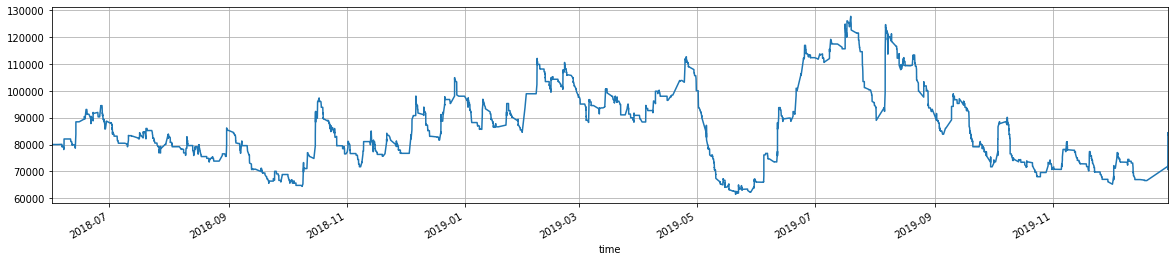

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

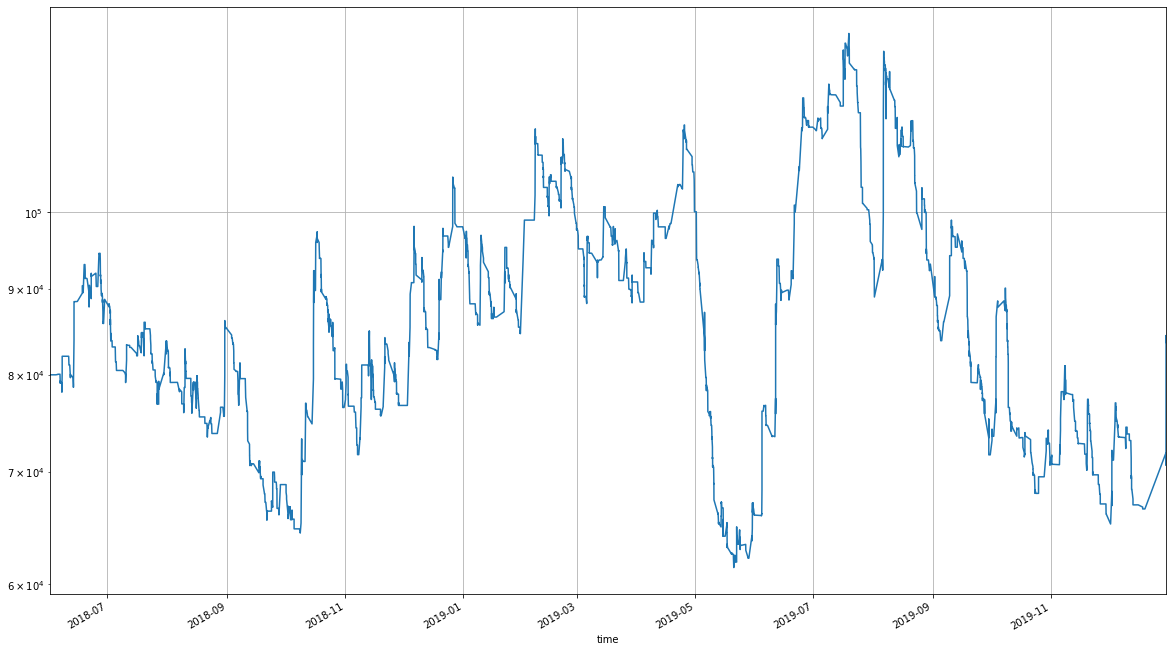

In [7]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,ES,YM,NQ,GC
time,,,,
2018-06-30,0.761905,0.800000,2.857143,1.809524
2018-07-31,0.909091,0.545455,2.363636,2.636364
2018-08-31,0.521739,1.043478,2.608696,2.434783
2018-09-30,1.100000,1.100000,3.400000,2.300000
2018-10-31,1.739130,1.478261,4.869565,2.521739
2018-11-30,1.363636,1.272727,5.272727,1.727273
2018-12-31,1.428571,2.095238,3.809524,1.714286
2019-01-31,1.130435,1.478261,3.086957,1.695652
2019-02-28,0.700000,0.900000,3.850000,2.150000


In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     428
 GC     940
 NQ    1388
 YM     468
 Name: action, dtype: int64, 3224)

In [11]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.038835
 GC    2.281553
 NQ    3.368932
 YM    1.135922
 Name: action, dtype: float64, 7.825242718446602)

In [12]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES       1095.88
GC       3498.90
NQ       3721.92
YM       1256.96
total    9573.66
Name: commission, dtype: float64

In [13]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES         3.0
GC        -7.2
NQ       -36.6
YM         4.9
total    263.2
dtype: float64

In [14]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.26,-75.02,982.85,-442.84,2.22,-72.16,1.34,469.0,629.2
NQ,0.20,22.71,1919.86,-465.33,4.13,11.71,1.00,694.0,690.8
YM,0.35,146.18,1623.02,-650.54,2.49,145.21,1.00,234.0,234.4
ES,0.41,135.99,1598.73,-866.05,1.85,144.51,0.96,214.0,206.2
total,0.27,27.24,1536.39,-525.73,2.92,31.04,1.09,1611.0,1760.6


In [15]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC      -0.626154
NQ       0.130000
YM       0.632857
ES       0.410976
total    0.216296
dtype: float64

In [16]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.0,0.00,0.00,0.00,0.00
2018-06-04,0.0,0.00,0.00,0.00,0.00
2018-06-05,0.0,258.96,0.00,0.00,64.74
2018-06-06,0.0,-3953.04,0.00,0.00,-988.26
2018-06-07,0.0,-3845.04,15795.36,0.00,2987.58
...,...,...,...,...,...
2019-12-24,0.0,0.00,0.00,0.00,0.00
2019-12-25,0.0,0.00,0.00,0.00,0.00
2019-12-26,0.0,0.00,0.00,0.00,0.00


In [17]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-04,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-05,0.000000,0.000809,0.000000,0.000000,0.000809
2018-06-06,0.000000,-0.012343,0.000000,0.000000,-0.012343
2018-06-07,0.000000,-0.012156,0.049937,0.000000,0.037781
...,...,...,...,...,...
2019-12-24,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

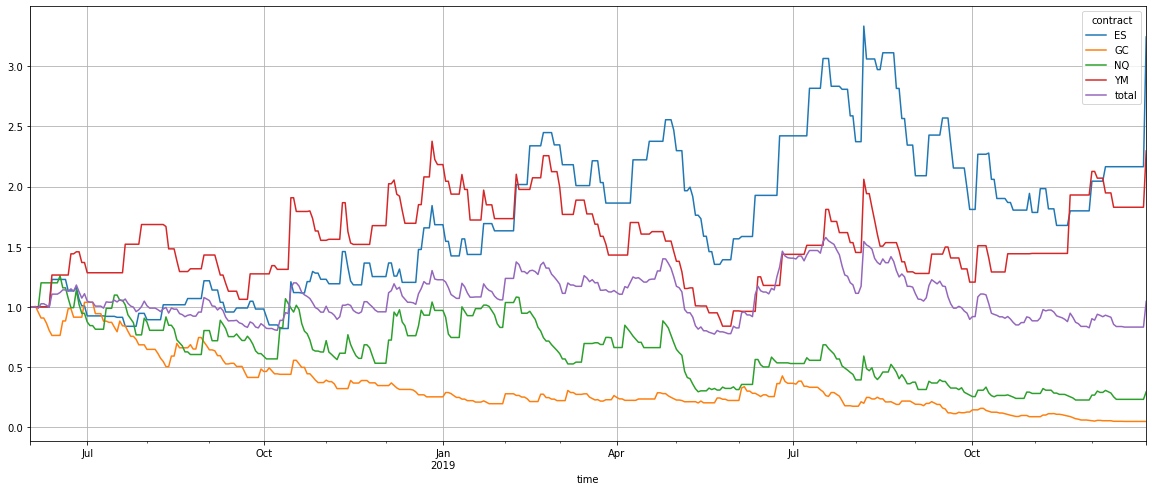

In [19]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.105344,0.356397,0.592136,0.697175
GC,-0.105344,1.000000,0.000116,-0.045335,0.368149
NQ,0.356397,0.000116,1.000000,0.249648,0.718662
YM,0.592136,-0.045335,0.249648,1.000000,0.665728
total,0.697175,0.368149,0.718662,0.665728,1.000000


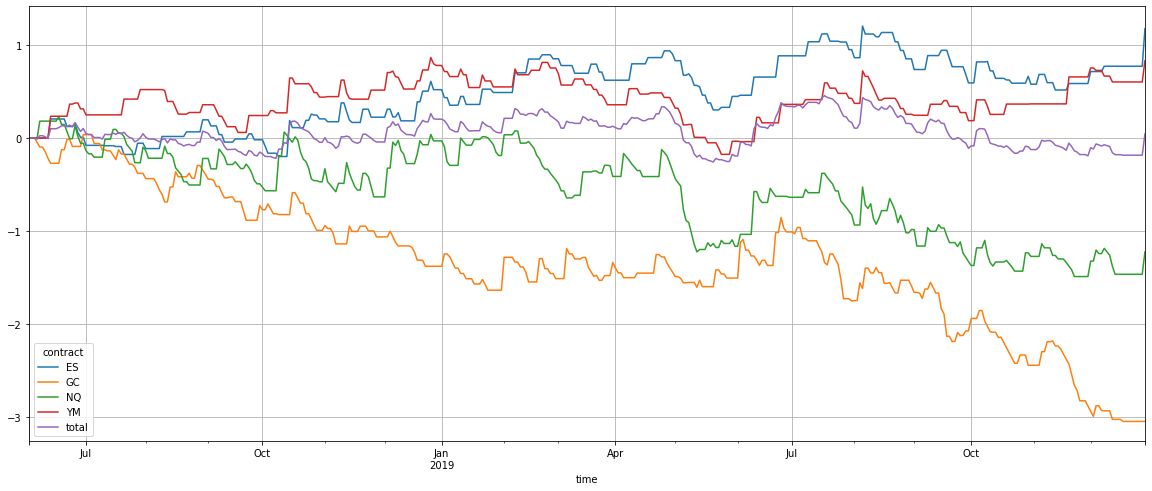

In [21]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

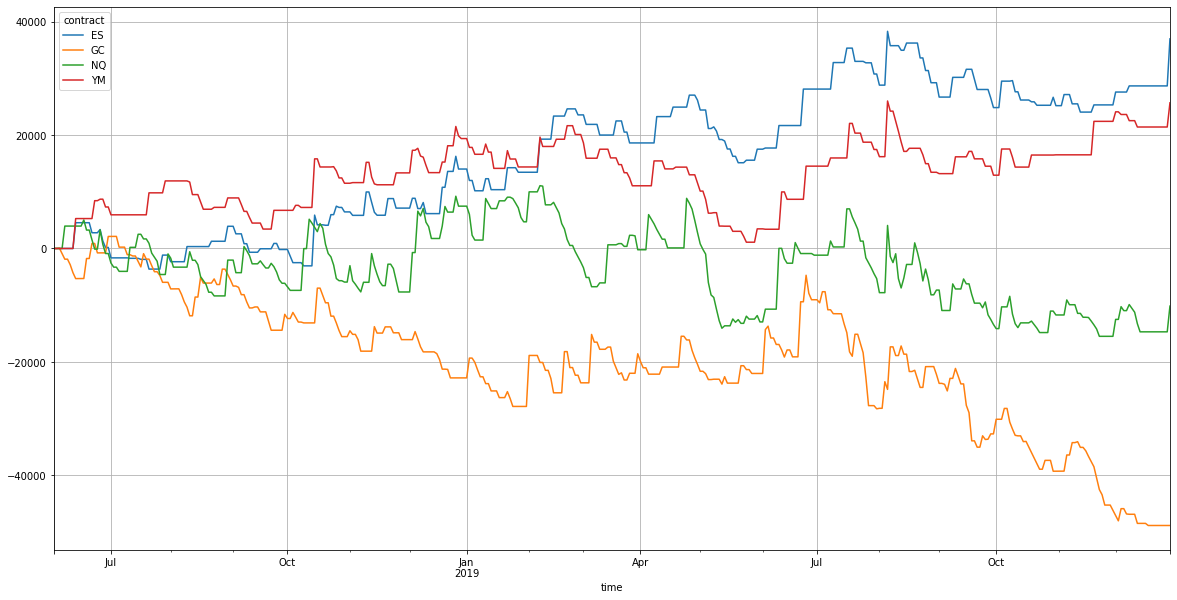

In [22]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [23]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.054110,-0.844919,-0.526910,0.662844,0.027571
Cumulative returns,2.244255,-0.952507,-0.705857,1.296544,0.045470
Annual volatility,1.036495,1.171517,1.441899,0.991498,0.717869
Sharpe ratio,1.152360,-1.056602,0.117254,0.952557,0.372671
Calmar ratio,2.120880,-0.885424,-0.642010,1.024730,0.057911
Stability,0.644856,0.822197,0.714875,0.014382,0.000542
Max drawdown,-0.497015,-0.954254,-0.820719,-0.646848,-0.476095
Omega ratio,1.443706,0.778560,1.027842,1.358824,1.081725
Sortino ratio,2.595445,-1.923054,0.242056,2.217517,0.761395
Skew,3.381473,2.653524,2.544797,3.310481,2.514670


In [24]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.304933,-0.296185,-0.020029,0.229245,0.027571
Cumulative returns,0.545175,-0.436872,-0.032537,0.401366,0.045470
Annual volatility,0.259124,0.292879,0.360475,0.247874,0.717869
Sharpe ratio,1.152360,-1.056602,0.117254,0.952557,0.372671
Calmar ratio,2.144824,-0.664325,-0.080776,1.087618,0.057911
Stability,0.804077,0.620994,0.046946,0.396383,0.000542
Max drawdown,-0.142172,-0.445844,-0.247955,-0.210777,-0.476095
Omega ratio,1.443706,0.778560,1.027842,1.358824,1.081725
Sortino ratio,2.595445,-1.923054,0.242056,2.217517,0.761395
Skew,3.381473,2.653524,2.544797,3.310481,2.514670


In [25]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,0.79,1.61,-0.51,8.96,10.92
2018-07-31,-1.32,-9.52,-0.01,5.77,-5.54
2018-08-31,6.90,0.71,-1.68,-3.72,1.70
2018-09-30,-4.98,-7.53,-5.82,-2.39,-19.28
2018-10-31,7.68,-5.56,3.13,6.69,11.16
2018-11-30,1.30,-1.08,-2.29,2.53,0.28
2018-12-31,8.70,-7.36,19.12,7.78,27.79
2019-01-31,-0.21,-5.83,-2.58,-5.04,-13.63
2019-02-28,10.25,5.46,-5.55,5.76,15.25


In [26]:
monthly_returns.total.mean(), monthly_returns.total.median()

(2.4436842105263152, -1.3599999999999999)

In [27]:
monthly_returns.sort_values('total', ascending = False).total

time
2019-06-30    70.33
2018-12-31    27.79
2019-12-31    26.58
2019-02-28    15.25
2018-10-31    11.16
2018-06-30    10.92
2019-04-30    10.12
2018-08-31     1.70
2018-11-30     0.28
2019-10-31    -1.36
2019-08-31    -1.58
2018-07-31    -5.54
2019-11-30    -6.54
2019-03-31    -6.87
2019-01-31   -13.63
2019-07-31   -15.81
2018-09-30   -19.28
2019-09-30   -23.03
2019-05-31   -34.06
Name: total, dtype: float64

In [28]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       55.0
GC      -44.0
NQ       -3.0
YM       40.0
total     5.0
dtype: float64

In [29]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-02-01 04:00:00,GC,SELL,1322.50,8985.48
2019-08-06 15:34:30,YM,BUY,25872.00,8921.60
2019-12-30 16:11:30,ES,SELL,3224.75,8291.60
2019-06-11 18:27:30,NQ,SELL,7506.25,8245.80
2019-03-06 07:53:30,GC,BUY,1291.00,7995.48
...,...,...,...,...
2019-08-22 16:36:00,ES,SELL,2905.50,-2383.40
2019-05-06 00:00:00,NQ,SELL,7734.00,-2578.40
2019-07-25 14:34:00,GC,SELL,1423.00,-2594.52


In [30]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-08-06,9487.34,-1362.30,11845.12,9812.72,29782.88
2019-12-30,8291.60,0.00,4535.38,4262.34,17089.32
2018-10-15,8943.28,0.00,-734.20,8565.28,16774.36
2019-06-11,3962.97,0.00,10717.98,0.00,14680.95
2019-02-01,0.00,8985.48,5281.60,0.00,14267.08
...,...,...,...,...,...
2019-05-01,-1736.23,-1232.40,-2005.20,-1405.48,-6379.31
2019-10-10,-1973.27,-1110.36,-1697.42,-1729.84,-6510.89
2019-09-18,0.00,-4970.48,-1877.44,0.00,-6847.92


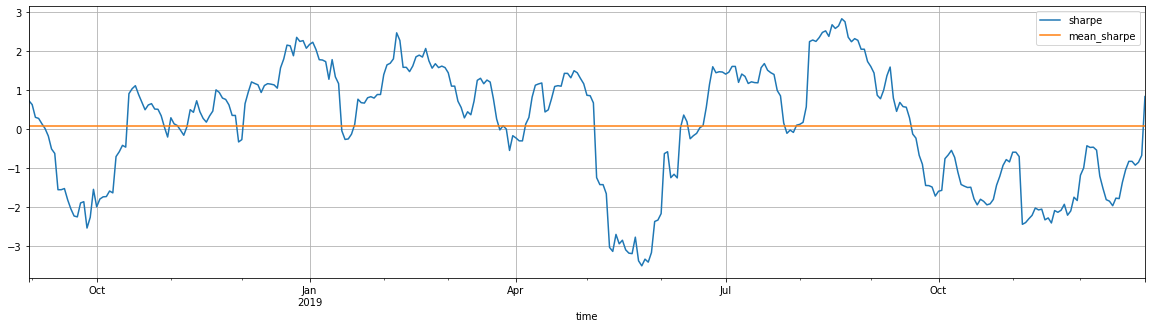

In [31]:
plot_rolling_sharpe(returns.total, 3)

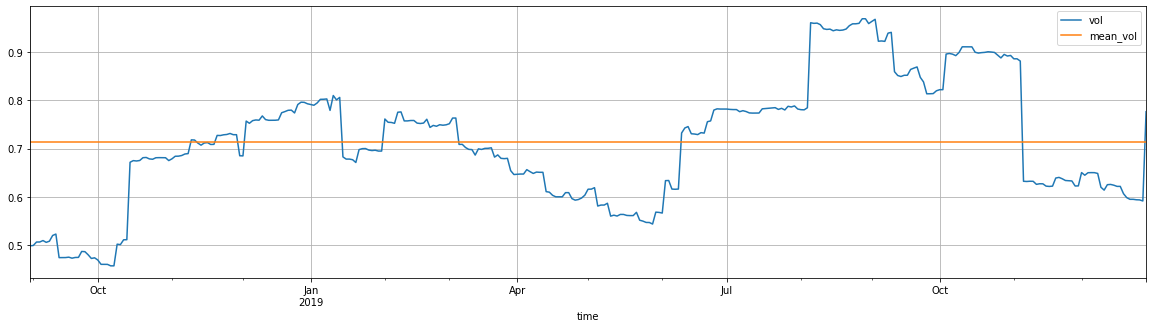

In [32]:
plot_rolling_vol(returns.total, 3)